In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../..')


%load_ext autoreload
%autoreload 2

%matplotlib inline  

import matplotlib.pyplot as plt 
import numpy as np


from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.polygon import orient
from shapely.affinity import scale, rotate, translate

from PIL import Image, ImageFont, ImageDraw

from joblib import dump, load

from tqdm.autonotebook import tqdm

from shared.nbs_helpers import draw_polys, draw_clusters, InParallelWithBar
from shared.utils import np_to_shapely, shapely_to_np

/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
from shared.td_datasets.mlt import ICDAR_MLT
from shared.td_datasets.coco import COCO
from shared.td_datasets.ubertext import UberText
from shared.td_datasets.synthtext import SynthText
from shared.td_datasets.synthtext import SynthTextClean

from PIL import Image
import pandas as pd

from shapely.geometry import box, Polygon
from shared.datasets.clusters import scale_to_square, cluster_polys, cluster_polys_np
from shared.datasets.clusters import np_to_sh_cluster, sh_cluster_crop, np_cluster_crop

import string

import h5py
from joblib import dump
from pathlib import Path

# Create SynthTextClean dataset

In [12]:
import h5py
from joblib import dump
from pathlib import Path


def unbox_hdf5_synthtext(src_h5, dst_dir):

    base = dst_dir 
    base.mkdir(exist_ok=True)
    (base / 'imgs-orig').mkdir(exist_ok=True)
    (base /  'imgs-wbg').mkdir(exist_ok=True)

    
    db = h5py.File(src_h5,'r')   
    
    def go(x):
        x = x.split('_')
        return '_'.join(x[:-2]), x[-2], int(x[-1])
    imgs = map(go, db['data'].keys())
    imgs = sorted((name, num) for name, type, num  in imgs if type == 'orig' )

    data = {}

    for name, num in tqdm(imgs):
        
        img_name = str(num) + '-'+ name
        
        img_key = name + '_orig_' + str(num)
        
        Image.fromarray(np.array(db['data'][img_key])).save(base/'imgs-orig'/img_name)
        Image.fromarray(np.array(db['data'][name + '_wbg_' + str(num)])).save(base/'imgs-wbg'/img_name)


        data[img_name] = {
            'txt' : db['data'][img_key].attrs['txt'], 
            'wordBB' : db['data'][img_key].attrs['wordBB'], 
        }

    dump(data, base/'data.pkl')



In [13]:
src_h5 = Path('~/data/tx/sythtext-results/SynthText7.h5').expanduser()


In [ ]:
# for i in [2, 3, 4, 5]:
base_dir = Path('~/data/tx/').expanduser()
for i in [6,7]:
    dst_dir = base_dir/f'sythtext-results-unboxed-{i}'
    src_h5  = base_dir/f'sythtext-results/SynthText{i}.h5'
    
    unbox_hdf5_synthtext(src_h5=src_h5, dst_dir=dst_dir)

In [ ]:

ps = [ Path(f'~/data/tx/sythtext-results-unboxed-{i}').expanduser() for i in [7] ] 

ds = SynthTextClean(ps[0])

In [35]:
len(ds)

7978

In [29]:
img_paths, polys_np, lables, langs, attrs =  ds[105]

plt.figure(figsize=(10,10))
plt.subplot(122)
plt.imshow(Image.open(img_paths['orig']))

plt.subplot(121)
plt.imshow(Image.open(img_paths['wbg']))

IndexError: list index out of range

# Load the text-boxes dataframe

In [ ]:
df = pd.read_msgpack('text-boxes-2.msgpack')

# def conv(x):
#     if not isinstance(x, np.ndarray):
#         return np.array(x)
#     return x

# df.polygon = df.polygon.map(conv)

# Build text-boxes dataframe

In [3]:
def _add_props(df):

    def poly_area(x):
        try:
            return Polygon(x).area
        except:
            return float('nan')

    df['poly_area'] = df.polygon.map(poly_area)
    
    df['img_area'] = df.image_h * df.image_w
    df['is_printable'] = df.text.map(lambda x: set.issubset(set(x), string.printable))
    df['poly_vxs'] = df.polygon.apply(lambda p: len(p))

    def poly_env_dims(x):
        try: 
            minx, miny, maxx, maxy = Polygon(x).bounds
            return max(maxx - minx, maxy - miny)
        except:
            return float('nan')

    df['max_poly_env_dim'] = df.polygon.map(poly_env_dims)
    
    df.image = df.image.map(str)
    def conv(x):
        if not isinstance(x, np.ndarray):
            return np.array(x)
        return x
    df.polygon = df.polygon.map(conv)
    


In [4]:
_df = []

In [11]:
ds = ICDAR_MLT()

for img_path, polys_np, lables, langs in tqdm(ds):
    w, h  = Image.open(img_path).size
    for poly_id, (poly_np, label, lang) in enumerate(zip(polys_np, lables, langs)):
        _df.append(['mlt', img_path, w, h, poly_np, poly_id, label, lang, 'legible', 'machine printed' ])

In [8]:
ds = COCO(train=True)

for img_path, polys_np, lables, attrs, langs in tqdm(ds):
    w, h  = Image.open(img_path).size
    for poly_id, (poly_np, label, lang, attr) in enumerate(zip(polys_np, lables, langs, attrs)):
        _df.append(['coco', img_path, w, h, poly_np, poly_id, label, lang, attr['legibility'], attr['class'] ])

    
ds = UberText(need_4k=True)

for img_path, polys_np, lables, langs, attrs in tqdm(ds):
    w, h  = Image.open(img_path).size
    for poly_id, (poly_np, label, lang, attr) in enumerate(zip(polys_np, lables, langs, attrs)):
        _df.append(['ubr', img_path, w, h, poly_np, poly_id, label, lang, 'legible', attr ])
    

loading annotations into memory...
0:00:03.194624
creating index...
index created!



gt_dir  /media/disk1/anerinovsky/data/tx/gt


In [ ]:
ds = SynthText()
for img_path, polys_np, lables, langs, attrs in tqdm(ds):
    w, h  = Image.open(img_path).size
    
    if len(lables) != len(polys_np):
        print('Oh NO!')
    
    for poly_id, (poly_np, label, lang, attr) in enumerate(zip(polys_np, lables, langs, attrs)):
        _df.append(['synth', img_path, w, h, poly_np, poly_id, label, lang, 'legible', attr ])

In [7]:

for i in tqdm([2, 3, 4, 5, 6, 7]):

    p = Path(f'~/data/tx/sythtext-results-unboxed-{i}').expanduser()
    ds = SynthTextClean(p)
        
    for img_paths, polys_np, lables, langs, attrs in tqdm(ds):
        w, h  = Image.open(img_paths['orig']).size

        if len(lables) != len(polys_np):
            print('Oh NO!')
        
        for poly_id, (poly_np, label, lang, attr) in enumerate(zip(polys_np, lables, langs, attrs)):
            attr['wbg_img_path'] = img_paths['wbg']
            _df.append(['synth', img_paths['orig'], w, h, poly_np, poly_id, label, lang, 'legible', attr ])

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/home/anerinovsky/data/tx/sythtext-results-unboxed-6/imgs-orig/ant+hill_10.jpg_orig_0'

In [10]:
!ls /nfs/home/anerinovsky/data/tx/sythtext-results-unboxed-6/imgs-wbg

0-ant+hill_100.png	    0-leopard_62.jpg
0-ant+hill_102.jpg	    0-leopard_65.jpg
0-ant+hill_106.jpg	    0-leopard_67.jpg
0-ant+hill_107.jpg	    0-leopard_76.jpg
0-ant+hill_10.jpg	    0-leopard_78.jpg
0-ant+hill_110.jpg	    0-leopard_84.jpg
0-ant+hill_111.jpg	    0-leopard_87.jpg
0-ant+hill_113.jpg	    0-leopard_88.jpg
0-ant+hill_114.jpg	    0-leopard_8.jpg
0-ant+hill_115.jpg	    0-leopard_90.jpg
0-ant+hill_116.jpg	    0-leopard_92.jpg
0-ant+hill_122.jpg	    0-leopard_94.jpg
0-ant+hill_124.jpg	    0-leopard_96.jpg
0-ant+hill_125.jpg	    0-leopard_99.jpg
0-ant+hill_126.jpg	    0-leopard_9.jpg
0-ant+hill_127.jpg	    0-lion_0.jpg
0-ant+hill_129.jpg	    0-lion_100.jpg
0-ant+hill_12.jpg	    0-lion_103.jpg
0-ant+hill_130.jpg	    0-lion_106.png
0-ant+hill_131.jpg	    0-lion_108.jpg
0-ant+hill_133.jpg	    0-lion_109.jpg
0-ant+hill_135.jpg	    0-lion_116.jpg
0-ant+hill_136.jpg	    0-lion_118.jpg
0-ant+hill_13.jpg	    0-lion_119.jpg
0-ant+hill_140.jpg	    0-lion_122.jpg
0-ant+hill_145.jpg	    0-li

0-cambridge_56.jpg	    0-peacock_29.jpg
0-cambridge_60.jpg	    0-peacock_2.jpg
0-cambridge_61.jpg	    0-peacock_32.jpg
0-cambridge_63.jpg	    0-peacock_33.jpg
0-cambridge_64.jpg	    0-peacock_34.jpg
0-cambridge_68.jpg	    0-peacock_35.jpg
0-cambridge_69.jpg	    0-peacock_36.jpg
0-cambridge_6.jpg	    0-peacock_38.jpeg
0-cambridge_70.jpg	    0-peacock_3.jpg
0-cambridge_76.jpg	    0-peacock_40.jpg
0-cambridge_77.jpg	    0-peacock_42.jpg
0-cambridge_79.jpg	    0-peacock_46.jpg
0-cambridge_80.jpg	    0-peacock_4.jpg
0-cambridge_82.jpg	    0-peacock_50.jpg
0-cambridge_84.jpg	    0-peacock_51.jpg
0-cambridge_85.jpg	    0-peacock_58.jpg
0-cambridge_92.jpg	    0-peacock_59.jpg
0-cambridge_93.jpg	    0-peacock_61.jpeg
0-cambridge_96.jpg	    0-peacock_62.jpg
0-cambridge_98.jpg	    0-peacock_64.jpg
0-cambridge_99.jpg	    0-peacock_65.jpg
0-camping_101.jpg	    0-peacock_66.jpeg
0-camping_102.jpg	    0-peacock_68.jpg
0-camping_103.jpg	    0-peacock_6.jpg
0-camping_106.jpg	    0-peacock_70.jpg
0-camp

In [68]:
df0 = pd.DataFrame(_df, columns=['dataset', 'image', 'image_w', 'image_h', 'polygon','polygon_id', 'text', 'language', 'legibility', 'cls'])

_add_props(df0)

In [94]:
# df0.to_msgpack('text-boxes-2.msgpack')

/nfs/home/anerinovsky/miniconda3/envs/c3d/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


In [70]:
df = df0

In [89]:
len(df)

340080

In [71]:
df

dataset                                              image  image_w  \
0        synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
1        synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
2        synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
3        synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
4        synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
...        ...                                                ...      ...   
340075   synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
340076   synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
340077   synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
340078   synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   
340079   synth  /nfs/home/anerinovsky/data/tx/sythtext-results...      600   

        image_h                                            polygon  \
0           530  [[228.3883, 33.80198], [301.21112, 35.21998], ...   
1           530  [[256.19696, 148.62653], [352.549, 116.59665],...   
2           530  [[365.4369, 113.82004], [422.91583, 91.575806]...   
3           530  [[446.5445, 7.1375732], [524.3262, 18.066025],...   
4           530  [[541.42285, 11.54414], [569.4939, 11.154011],...   
...         ...                                                ...   
340075      398  [[347.19867, 24.26242], [380.7345, 24.687897],...   
340076      398  [[395.96088, 20.737183], [442.21912, 31.45562]...   
340077      398  [[152.82166, 275.6849], [158.46973, 246.10092]...   
340078      398  [[172.72372, 285.4269], [176.9031, 250.20187],...   
340079      398  [[54.34957, 62.229984], [121.53176, 61.805603]...   

        polygon_id                text language legibility  \
0                0               From:  english    legible   
1                1           Larry Hsu  english    legible   
2                2      were to\nyou'd  english    legible   
3                3   giant  \na liquid  english    legible   
4                4           the\nnear  english    legible   
...            ...                 ...      ...        ...   
340075           5                 the  english    legible   
340076           6               can't  english    legible   
340077           7                 can  english    legible   
340078           8                text  english    legible   
340079           9                text  english    legible   

                                                      cls    poly_area  \
0       {'wbg_img_path': '/nfs/home/anerinovsky/data/t...  2096.227458   
1       {'wbg_img_path': '/nfs/home/anerinovsky/data/t...  6976.528544   
2       {'wbg_img_path': '/nfs/home/anerinovsky/data/t...  4335.127388   
3       {'wbg_img_path': '/nfs/home/anerinovsky/data/t...  2421.917132   
4       {'wbg_img_path': '/nfs/home/anerinovsky/data/t...  1248.907941   
...                                                   ...          ...   
340075  {'wbg_img_path': '/nfs/home/anerinovsky/data/t...   793.949914   
340076  {'wbg_img_path': '/nfs/home/anerinovsky/data/t...  1462.876394   
340077  {'wbg_img_path': '/nfs/home/anerinovsky/data/t...   679.093867   
340078  {'wbg_img_path': '/nfs/home/anerinovsky/data/t...   635.857875   
340079  {'wbg_img_path': '/nfs/home/anerinovsky/data/t...  1564.262462   

        img_area  is_printable  poly_vxs  max_poly_env_dim  
0         318000          True         4         73.383133  
1         318000          True         4        118.026672  
2         318000          True         4         87.841095  
3         318000          True         4         82.071808  
4         318000          True         4         44.872505  
...          ...           ...       ...               ...  
340075    238800          True         4         33.836121  
340076    238800          True         4         53.212463  
340077    238800          True         4      

# EDA

### Explore characters

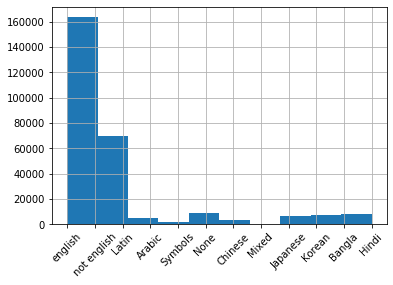

In [96]:
df.language.hist(xrot=45)

In [60]:
chars = lambda ss: ''.join(sorted(set.union(*map(set, ss))))

In [61]:
chars(df[df.language == 'english'].text)

' !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]_`abcdefghijklmnopqrstuvwxyz{|~°'

In [62]:
chars(df[df.language == 'not english'].text)

" #%&'*./0123456789;=ABCDEFGHIKLMNOPQRSTUVWXYZ\\abcdefghiklmnoprstuvwxyz"

In [64]:
chars(df[df.language == 'Latin'].text)

'!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]_`abcdefghijklmnopqrstuvwxyz|~£¥°²·ÀÁÂÃÄÇÈÉÊËÌÎÑÒÔÖ×ÙÜßàáâãäçèéêìîòóôöùúûüĀōŒœŠūŸƹɑʒˉΦαβδεШзлфчاحـل۸गमरळाु्ᄋṠ–—‘’“”₩€™▪●、《》・之乐会分声学年新梦院音공과국디료무샵아에원월위인일자장주차총치트평한현'

### Explore polygons

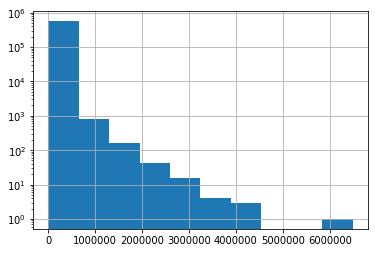

In [171]:
df.poly_area[~df.poly_area.isna() & (df.poly_area < df.img_area)].hist(log=True)

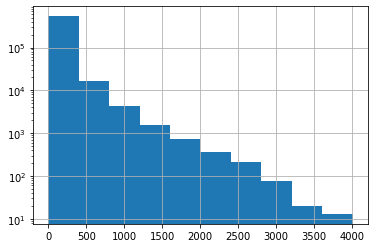

In [172]:
df.max_poly_env_dim.hist(log=True)

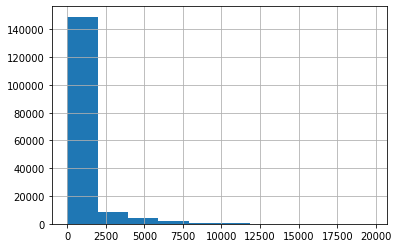

In [99]:
r = df.poly_area/df.img_area

(r[r<0.001]*df.img_area).hist()

### Create mask

In [4]:


mask  = df.is_printable & df.text.notna() & (df.poly_vxs == 4) & (df.text.str.len() >= 2) & ( df.legibility == 'legible' )

mask.sum(), len(df[mask].image.unique())

(7379752, 876339)

In [7]:
cnts = df.groupby('image').count()
cnts = np.array(cnts.dataset) 

(array([10348.,  9630.,  3413.,  1832.,   885.,   788.,   517.,   357.,
          251.,   178.]),
 array([ 1. ,  4.8,  8.6, 12.4, 16.2, 20. , 23.8, 27.6, 31.4, 35.2, 39. ]),
 <a list of 10 Patch objects>)

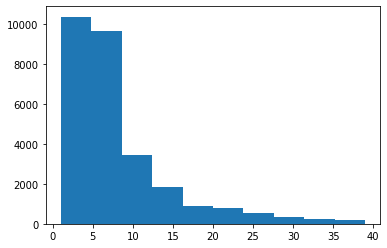

In [8]:
n_cnts = cnts/cnts.max()
plt.hist(n_cnts[n_cnts < 0.1]*cnts.max())

### Explore polys ++

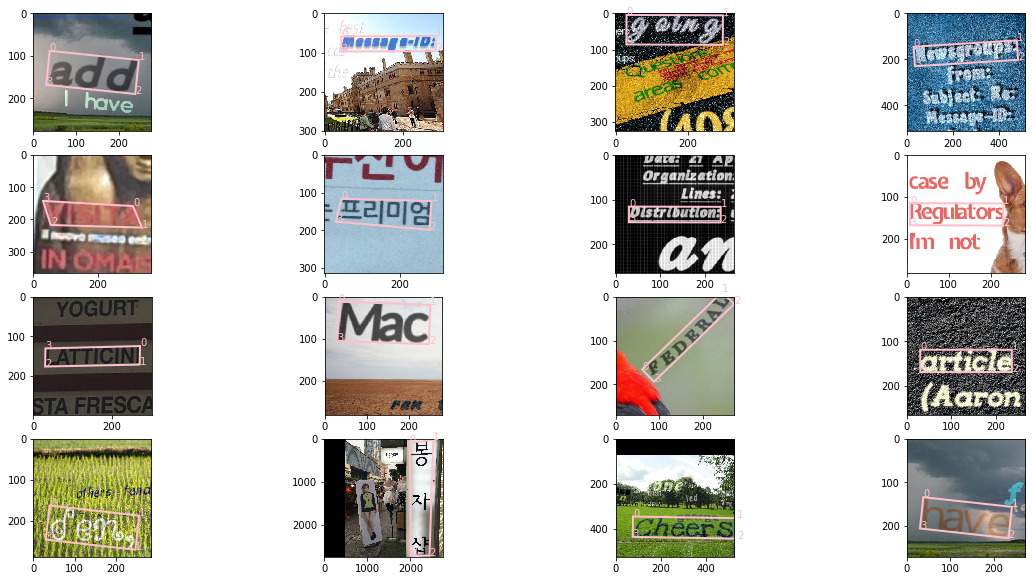

In [99]:
# def plot_poly()
# plt.imshow(Image.open(df.image))
# draw_poly()
from shared.clusters import scale_to_square
from shapely.affinity import translate


from shared.utils import np_to_shapely, shapely_to_np

df.max_poly_env_dim

def draw_row(row):
    img = Image.open(row.image)

    poly_sh = np_to_shapely(row.polygon)
    crop = scale_to_square(poly_sh.envelope, 60, interpret_scale_as_pixes=True)
    
    crop = adjust_crop_to_image(crop, row.image_w, row.image_h)
    
    plt.imshow(img.crop(box=crop.bounds))

    minx, miny, maxx, maxy = crop.bounds
    poly_sh = translate(poly_sh, -minx, -miny)

    draw_polys([poly_sh], plt.gca())


    
plt.figure(figsize=(20, 10))

mask = (df.max_poly_env_dim > 200) 

nrows, ncols = 4, 4
for i in range(ncols*nrows):
    plt.subplot(nrows, ncols, i+1)
    draw_row(df[mask].sample().iloc[0])


In [5]:
mask_full = ((df.max_poly_env_dim > 200) & mask )
mask_full.sum()

266451

# Cluster polys

## Clustering V1

#  4 clusters
Text:  ['INBOX-', 'OPEN', 'From:', 'Bodyshots', 'FAIL!', 'BODYSHOT', '', 'MOTOROLA', 'EV', 'Options', 'REPLY', 'pm', '57', '11', '16', 'Aug', 'Sat', 'men', 'of', 'off', 'Sjm']
Lang:  ['english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english']


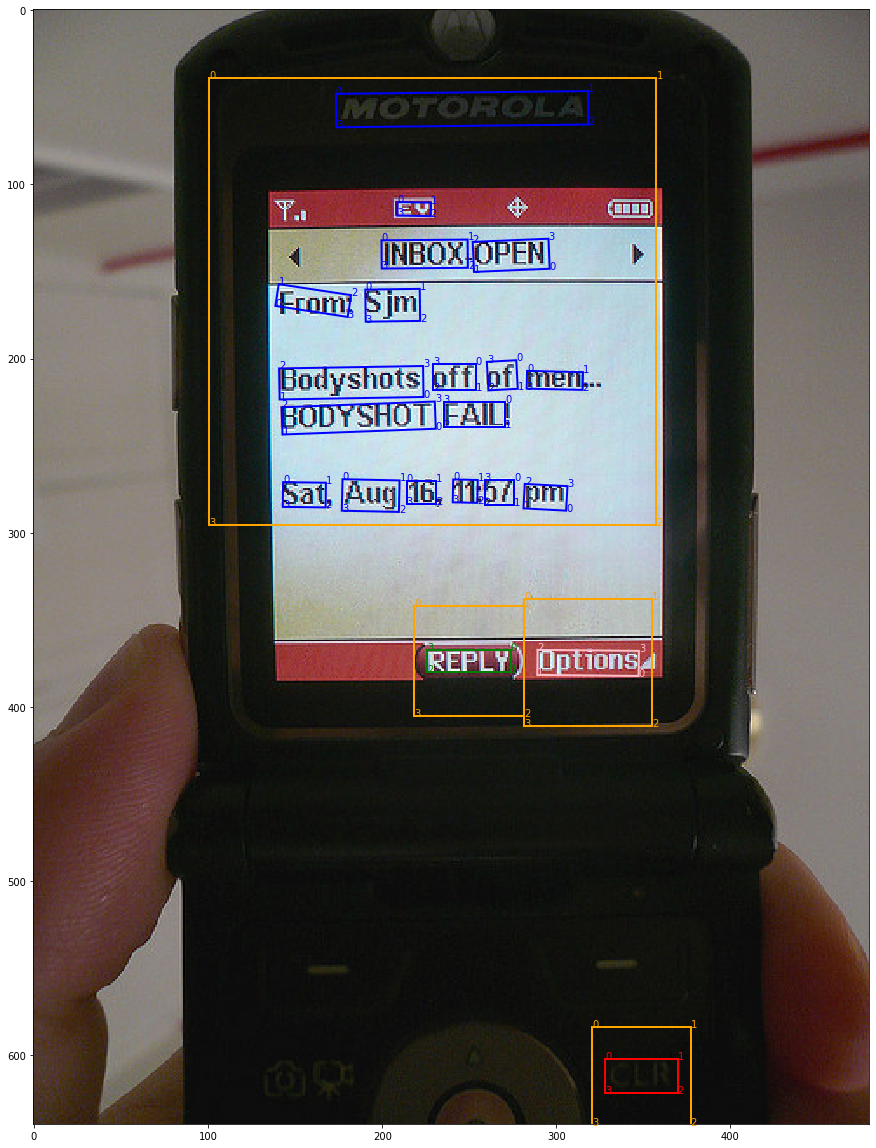

In [76]:
    
import itertools as it

# bad clusters 3115 at 1.6
img_path = df.image.unique()[2231]
# img_path = '/media/disk1/anerinovsky/data/tx/images/tr_img_07079.jpg'


# polys_sh = list(map(np_to_shapely, df[df.image == img_path].polygon))
# clusters = cluster_polys(polys_sh, 1.6, use_rects=True)

scale_args = dict(env_scale=15, interpret_scale_as_pixes=True, need_square=True)


clusters = cluster_polys_np(df[df.image == img_path].polygon, **scale_args)

print("# ", len(clusters), 'clusters')
print("Text: ", df[df.image == img_path].text.tolist())
print("Lang: ", df[df.image == img_path].language.tolist())
# print("Dataset: ", df[df.image == img_path].dataset.iloc[0])

        
img = Image.open(img_path)
plt.gcf().set_size_inches(30.5, 20.5)
plt.imshow(img)

draw_clusters(clusters, **scale_args)

## Cluster all polys V1

In [17]:
from multiprocessing import Manager, Pool, Value


img_paths = df[mask].image.unique()

# images_with_clusters = load('images_with_clusters')


images_with_clusters = {}
unfinished_images = list(set(img_paths) - set(images_with_clusters))

manager = Manager()
images_with_clusters = manager.dict((images_with_clusters))
failed_images = manager.list()


len(unfinished_images)

17589

In [18]:
n_workers = 10

counter = Value('i', 0)


def worker(w_id):
    for img_path in unfinished_images[w_id::n_workers]:
        try: 
            clusters = cluster_polys_np(df[df.image == img_path].polygon, env_scale=1.6)
            images_with_clusters[img_path] = clusters
        except:
            failed_images.append(img_path)
        
        with counter.get_lock():
            counter.value += 1
    
# worker(0)

with Pool(processes=n_workers) as pool:
    
    res = pool.map_async(worker, range(n_workers))
    
    bar = tqdm(total = len(unfinished_images))
    
    while not res.ready():    
        res.wait(1)
        
        with counter.get_lock():
            counter.value, cnt = 0, counter.value
            
        bar.update(cnt)


ERROR:shapely.geos:IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
ERROR:shapely.geos:Shell is not a LinearRing
ERROR:shapely.geos:IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
ERROR:shapely.geos:Shell is not a LinearRing


In [93]:
len(failed_images)

0

In [ ]:
# dump(dict(images_with_clusters), 'images_with_clusters_better_clusters')

## Clustering V2

In [76]:
 len(df.image.unique())

31920

In [80]:
mask  = (df.max_poly_env_dim > 100) # & df.is_printable & df.text.notna() & (df.poly_vxs == 4) # & (df.text.str.len() >= 2) # & ( df.legibility == 'legible' )

mask.sum(), len(df[mask].image.unique())

(48585, 17679)

In [ ]:
mask = mask & (df.language == 'Latin')

In [14]:
mask = mask & (df.dataset == 'mlt')
mask.sum()

20896

In [84]:
imgs, polys, poly_ids = df[mask].image.tolist(), df[mask].polygon.tolist(), df[mask].polygon_id.tolist()
sizes = zip(df[mask].image_w.tolist(),df[mask].image_h.tolist())
attrs = df[mask].cls.tolist()

# main_boxes = list(zip(imgs, sizes, polys, poly_ids))

for img, size, poly, poly_id, attr in zip(imgs, sizes, polys, poly_ids, attrs):
    _img = { 'img_path' : img }
    if 'wbg_img_path' in attrs:
        _img['edges_img_path'] = attrs['wbg_img_path']
            
    main_boxes.append((_img, size, poly, poly_id))


In [83]:
def conv(x):
    if isinstance(x, (list, tuple)):
        return x
    else:
        return x.tolist()
    

_ds_df = df # [df.dataset == 'mlt']
    
n_imgs = len(_ds_df.image.unique())
boxes_lookup = list(
    tqdm(
        map(lambda x: 
                (x[0], x[1].map(conv).tolist()), 
            _ds_df.groupby('image')['polygon']), total=n_imgs))
boxes_lookup = dict(boxes_lookup)

In [19]:
def check_vars(main_boxes, boxes_lookup):
    main_imgs = {x[0] for x in main_boxes}
    all_imgs = set(boxes_lookup)
    
    assert main_imgs & all_imgs == main_imgs

check_vars(main_boxes, boxes_lookup)

In [90]:
dump( main_boxes, 'clusters_clsynth.main_boxes')

['clusters_clsynth.main_boxes']

In [91]:
dump( boxes_lookup, 'clusters_clsynth.boxes_lookup' )

['clusters_clsynth.boxes_lookup']

### Sharded boxes_lookup save

In [93]:
!mv clusters_clsynth.* ~/data/tx

In [72]:
# !cp ~/data/tx/clusters_v3.main_boxes ~/data/tx/clusters_v3.5.main_boxes
from pathlib import Path
p = Path('~/data/tx').expanduser()
list(p.glob('clusters_synthtext.boxes_lookup.shard.*'))

[PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.1'),
 PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.2'),
 PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.6'),
 PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.7'),
 PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.5'),
 PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.0'),
 PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.3'),
 PosixPath('/nfs/home/anerinovsky/data/tx/clusters_synthtext.boxes_lookup.shard.4')]

In [58]:
_main_boxes, _boxes_lookup = np.array(main_boxes), np.array(list(boxes_lookup.items()))

In [59]:
check_vars(_main_boxes, list(_boxes_lookup[:, 0]))

In [60]:
ixs = np.arange(len(_boxes_lookup), dtype=int)

In [61]:
n_shards = 8
for shard_ix in tqdm(range(n_shards)):
    _ixs = ixs[shard_ix::n_shards]
    dump(_boxes_lookup[_ixs], f'clusters_synthtext.boxes_lookup.shard.{shard_ix}' )

# Test the datasets

In [ ]:
base_dir = Path('~/data/tx').expanduser()
name = 'synthtext'
shards = base_dir.glob(f'clusters_{name}.boxes_lookup.shard.*')            
shards = [load(shard) for shard in tqdm(shards)]

self.boxes_lookup = dict(sum( (list(s) for s in shards), []))

In [46]:
shard_ixs = [ set(ixs[shard_ix::n_shards])
                for shard_ix in range(n_shards)]

shard_ixs = set.union(*shard_ixs)
shard_ixs == set(ixs)

True

In [49]:
shards = [load(f'clusters_v3.5.boxes_lookup.shard.{i}') for i in tqdm(range(n_shards))]

In [52]:
boxes_lookup0 = dict(sum( (list(s) for s in shards), []))
     

check_vars(main_boxes, boxes_lookup0)

In [171]:
# load(f'clusters_v3.5.shard.0')
# dict(_shards)
!ls clusters_v3.5.shard*

clusters_v3.5.shard.0  clusters_v3.5.shard.2  clusters_v3.5.shard.4
clusters_v3.5.shard.1  clusters_v3.5.shard.3


In [18]:
len({x[0] for x in main_boxes0} & set(boxes_lookup0)), len(set(boxes_lookup0))
len(main_boxes0), len(boxes_lookup0)

set(boxes_lookup0) - {x[0] for x in main_boxes0}

{'/nfs/home/anerinovsky/datasets/archives/SynthText/129/photos_42_71.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/100/leopard_87_67.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/113/museums+in+london_28_107.jpg',
 '/nfs/home/anerinovsky/data/tx/Uber-Text/train/4Kx4K/img_28804.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/103/living+room_31_9.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/126/peacock_4_28.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/137/punting_147_8.jpg',
 '/media/disk1/anerinovsky/data/tx/images/tr_img_01341.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/103/living+room_130_68.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/13/bay+area_142_26.jpg',
 '/nfs/home/anerinovsky/data/tx/Uber-Text/train/1Kx1K/img_12867.jpg',
 '/nfs/home/anerinovsky/data/tx/Uber-Text/train/1Kx1K/img_7162.jpg',
 '/nfs/home/anerinovsky/datasets/archives/SynthText/123/park_135_16.jpg',
 '/nfs/home/anerinovsky/datase

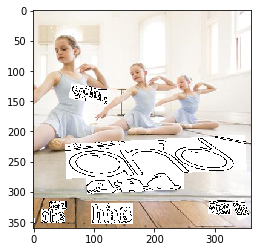

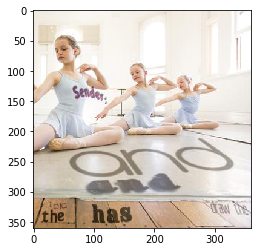

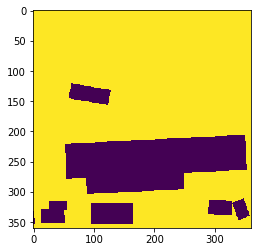

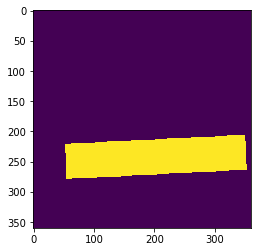

In [19]:
from skimage import feature
from shared.datasets_v2 import assamble_sample, compute_crop_and_cluster



img_path, crop, cluster = compute_crop_and_cluster(166, main_boxes, boxes_lookup)
img_with_edges, img, img_mask, masks = assamble_sample(img_path, crop, cluster)

plt.imshow(img_with_edges)
plt.show()


plt.imshow(img)
plt.show()

plt.imshow(img_mask)
plt.show()

plt.imshow(masks[0])
plt.show()